In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import RetinaDataset
from scvic.dataset import ExpressionDataset
from scvic.models import CVAE
from scvic.inference import CTrainer
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc
import anndata
import torch

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%matplotlib inline 

# Sets torch and numpy random seeds, run after all scvi imports
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 

/data/xiong/anaconda3/envs/scVIC/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "../Datasets/Biological Datasets"
gene_dataset = RetinaDataset(save_path=save_path)
gene_dataset.filter_genes_by_count(per_batch=True)
gene_dataset.subsample_genes(4000)
retina_dataset = ExpressionDataset()
retina_dataset.load_dataset_from_scVI(gene_dataset)

[2022-08-31 06:30:12,058] INFO - scvi.dataset.dataset | File /data/xiong/scVIC/notebooks/Datasets/Biological Datasets/retina.loom already downloaded
[2022-08-31 06:30:12,059] INFO - scvi.dataset.loom | Preprocessing dataset
[2022-08-31 06:30:22,788] INFO - scvi.dataset.loom | Finished preprocessing dataset
[2022-08-31 06:30:27,998] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2022-08-31 06:30:28,001] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2022-08-31 06:30:28,640] INFO - scvi.dataset.dataset | Downsampling from 13166 to 13085 genes
[2022-08-31 06:30:33,927] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-08-31 06:30:35,220] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2022-08-31 06:30:40,027] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-08-31 06:30:40,468] INFO - scvi.dataset.dataset | Downsampled from 19829 to 19829 cells
[2022-08-31 06:30:40,470] INFO - scvi.datase

In [3]:
n_epochs = 400
lr = 0.001
use_cuda = True
use_batches = True

In [4]:
retina_cvae = CVAE(retina_dataset.nb_genes, n_labels=retina_dataset.n_labels, n_batch=retina_dataset.n_batches * use_batches, n_latent=10)
ctrainer = CTrainer(
    retina_cvae,
    retina_dataset,
    train_size=1.0,
    use_cuda=use_cuda,
    n_epochs_kl_warmup=200,
    n_epochs_pre_train=200
)

ctrainer.train(n_epochs=n_epochs, lr=lr)

[2022-08-31 06:31:00,799] INFO - scvi.inference.inference | KL warmup for 200 epochs
training: 100%|███████████████████████████████| 400/400 [32:21<00:00,  4.85s/it]


In [5]:
full = ctrainer.create_posterior(ctrainer.model, retina_dataset, indices=np.arange(len(retina_dataset)))
# Updating the "minibatch" size after training is useful in low memory configurations
full = full.update({"batch_size":32})
latent, labels_pred = full.sequential().get_latent()

In [6]:
post_adata = anndata.AnnData(X=retina_dataset.X)
post_adata.obsm["X_scVIC"] = latent
post_adata.obs['cell_type'] = np.array([retina_dataset.cell_types[retina_dataset.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
post_adata.obs['batch'] = np.array([str(retina_dataset.batch_indices[i][0])
                                   for i in range(post_adata.n_obs)])
labels_pred=pd.Series(labels_pred, index=post_adata.obs.index, dtype='category')
labels_pred.cat.categories=list(range(len(labels_pred.unique())))
post_adata.obs['predicted_type'] = labels_pred
sc.pp.neighbors(post_adata, use_rep="X_scVIC", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.3)
show_plot = True

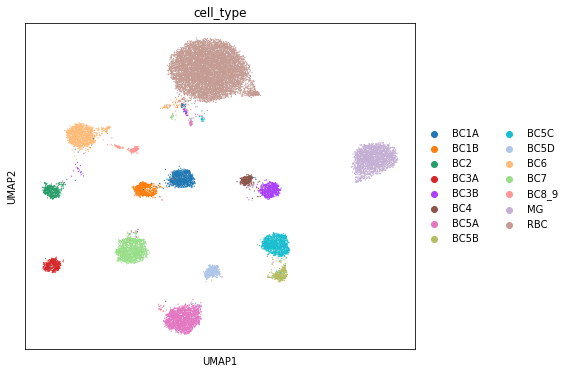

In [7]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)

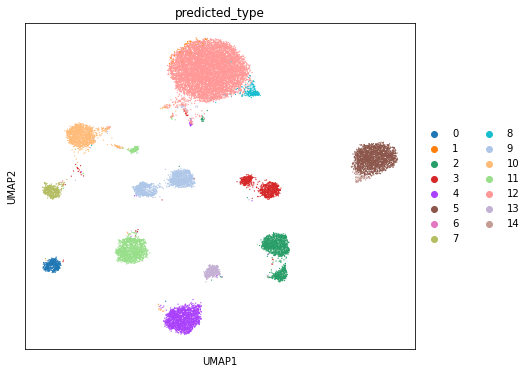

In [8]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["predicted_type"], ax=ax, show=show_plot)

In [9]:
print("RETINA_scVIC_ARI: ")
print(np.around(adjusted_rand_score(retina_dataset.labels.squeeze(), labels_pred), 5))
print("RETINA_scVIC_NMI: ")
print(np.around(normalized_mutual_info_score(retina_dataset.labels.squeeze(), labels_pred, average_method='arithmetic'), 5))        

RETINA_scVIC_ARI: 
0.91925
RETINA_scVIC_NMI: 
0.90199


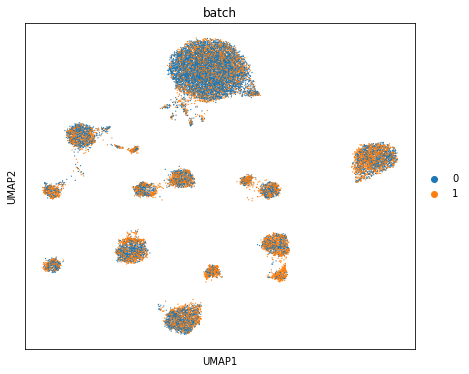

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["batch"], ax=ax, show=show_plot)

In [11]:
print("RETINA_scVIC_batch_mixing: ") 
print(np.around(full.entropy_batch_mixing(), 5))

RETINA_scVIC_batch_mixing: 
0.05531
